## ALS Antoine

In [5]:
#manuel
best_rmse_test_als = 2
best_k_als = 5
best_reg_user = 1e-8
best_reg_item = 0.01


## Import usefuls module

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math 
import dataiku
from itertools import groupby
from helpers import *
from helpers_antoine import *
from plots import *
import time
import scipy
import scipy.io
import numpy as np
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the data

number of items: 10000, number of users: 1000


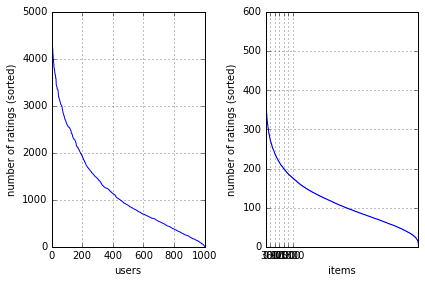

In [3]:
# write here the path to the dataset
path_dataset = "datasets/data_train.csv"

# load the data 
ratings = load_data(path_dataset)
num_items_per_user, num_users_per_item = plot_raw_data(ratings)

## Split the data 

In [89]:
# then select the items and users for which there are enough data
# and split the datan into a training set and a test set

# minimal number of data per user and per item
min_num_ratings = 1

# fraction of the data set that will be the test set 
p_test = 0.1

valid_ratings, train, test = split_data(ratings, num_items_per_user, num_users_per_item, min_num_ratings, p_test)
train = np.asarray(train.todense())
test = np.asarray(test.todense())
# plot the resulting training and test set 
#plot_train_test_data(train, test)

Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1059292
Total number of nonzero elements in test data:117660


## Matrix Factorization Using alternative Least Square Method 

### Time tests

In [ ]:
#Test of one loop of ALS, in order to identify how to make it faster.

max_K =3

# incrementation step for K
step_K = 1

# regularization parameters for the loss function 
lambda_user = 1e-8
lambda_item = 1e-5


# stop criterion
stop_criterion = 1e-2

# number of iterations of the alternative least squares method 
it_max = 10
K = 2
user_features, item_features, rmse_test = ALS(train, test, K, lambda_user, lambda_item, stop_criterion, it_max, True)

Preparation des données, init MF : 0.0 s
Preparation des données, regroupement des features : 3.23 s
Preparation des données, final step : 0.02 s
    Preparation of the update user: 0.0 s
    Loops for update user: 0.09 s
User features update: 0.09 s
Item features update: 0.41 s
Shape of prediction after resize: 1059292
Shape of M after resize: 1059292
        Calcul des non-zero indices: 0.25 s
        Adding all the indices: 0.59 s
Computation of the indicators: 0.91 s
    Preparation of the update user: 0.0 s
    Loops for update user: 0.09 s
User features update: 0.09 s
Item features update: 0.42 s
Shape of prediction after resize: 1059292
Shape of M after resize: 1059292
        Calcul des non-zero indices: 0.33 s
        Adding all the indices: 0.61 s
Computation of the indicators: 1.0 s
    Preparation of the update user: 0.0 s
    Loops for update user: 0.09 s
User features update: 0.09 s
Item features update: 0.42 s
Shape of prediction after resize: 1059292
Shape of M after re

### Main Grid Search

In [ ]:
## Perform matrix factorization through stochastic gradient descent, for different numbers of features
# (grid search on the number of feature)
# keep the best number of feature, and the associated factorization

## Parameters for the matrix factorization

# maximum number of features fixed
min_K = 3
max_K = 10

# incrementation step for K
step_K = 1

# regularization parameters for the loss function 
lambda_user = np.logspace(-9, 0, 10)
lambda_item = np.logspace(-9, 0, 10)

res_test= np.zeros((max_K-min_K+1,len(lambda_user),len(lambda_item)))

# stop criterion
stop_criterion = 1e-5

# number of iterations of the alternative least squares method 
it_max = 50

# initialization of variables refering to the matrix factorization for the best number
best_rmse_test_als = float('Inf')
best_k_als = 0
best_user_feat_als = np.zeros(1)
best_item_feat_als = np.zeros(1)

for K in range(min_K,max_K+1,step_K):
    
    
    for i, lu in enumerate(lambda_user):
        for j, li in enumerate(lambda_item):
            # compute the matrix factorization using alternative least squares method
            user_features, item_features, rmse_test = ALS(train, test, K, lu, li, stop_criterion, it_max)
            print("K="+str(K)+", L_user="+str(lu)+", l_item="+str(li) + ", RMSE=" + str(rmse_test))
            #print("rmse on test data for ", K, " features : ", rmse_test)
            res_test[K-min_K,i,j] = rmse_test
            
            if rmse_test < best_rmse_test_als:
                # better rmse => update the references
                best_rmse_test_als = rmse_test
                best_k_als = K
                best_reg_user = lu
                best_reg_item = li
                best_user_feat_als = user_features
                best_item_feat_als = item_features
        
# print the results
print("best number of features found : ", best_k_als)
print("rmse on the test set for this number of features : ", best_rmse_test_als)

K=3, L_user=1e-09, l_item=1e-09, RMSE=0.996052606558
K=3, L_user=1e-09, l_item=1e-08, RMSE=0.995854687243
K=3, L_user=1e-09, l_item=1e-07, RMSE=0.995701003573
K=3, L_user=1e-09, l_item=1e-06, RMSE=0.996358799832
K=3, L_user=1e-09, l_item=1e-05, RMSE=0.995269477825
K=3, L_user=1e-09, l_item=0.0001, RMSE=0.995150422496
K=3, L_user=1e-09, l_item=0.001, RMSE=0.994567916561
K=3, L_user=1e-09, l_item=0.01, RMSE=0.993852997011
K=3, L_user=1e-09, l_item=0.1, RMSE=0.992513078258
K=3, L_user=1e-09, l_item=1.0, RMSE=1.00050475067
K=3, L_user=1e-08, l_item=1e-09, RMSE=0.995793776065
K=3, L_user=1e-08, l_item=1e-08, RMSE=0.995866748597
K=3, L_user=1e-08, l_item=1e-07, RMSE=0.995944621416
K=3, L_user=1e-08, l_item=1e-06, RMSE=0.995322889861
K=3, L_user=1e-08, l_item=1e-05, RMSE=1.06608884904


## ALS Results and storage

In [ ]:
for K in range(min_K,max_K+1,step_K):
    
    print("als matrix factorization for the number of features : ", K)
    for i, lu in enumerate(lambda_user):
        for j, li in enumerate(lambda_item):
            print(res_test[K-min_K,i,j])

In [94]:
import dataiku
import pandas as pd


row_list  = []



for K in range(min_K,max_K+1,step_K):
    
    print("als matrix factorization for the number of features : ", K)
    for i, lu in enumerate(lambda_user):
        for j, li in enumerate(lambda_item):
            r = {}
            r['K'] = K
            r['li'] = li
            r['lu'] = lu
            r['val'] = res_test[K-min_K,i,j]
            row_list.append(r)
            #print(r)

output = pd.DataFrame(row_list)
#print(output)
output_df = dataiku.Dataset("res_sample")
output_df.write_with_schema(output)



('als matrix factorization for the number of features : ', 3)
('als matrix factorization for the number of features : ', 4)
('als matrix factorization for the number of features : ', 5)
('als matrix factorization for the number of features : ', 6)
('als matrix factorization for the number of features : ', 7)
('als matrix factorization for the number of features : ', 8)
('als matrix factorization for the number of features : ', 9)
('als matrix factorization for the number of features : ', 10)
800 rows successfully written (9sQ8wtmAu7)


### Estimation of the bias

In [7]:
# then select the items and users for which there are enough data
# and split the datan into a training set and a test set

# minimal number of data per user and per item
min_num_ratings = 1

# fraction of the data set that will be the test set 
p_test = 0

valid_ratings, train, test = split_data(ratings, num_items_per_user, num_users_per_item, min_num_ratings, p_test)
train = np.asarray(train.todense())
test = np.asarray(test.todense())

Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1176952
Total number of nonzero elements in test data:0


In [8]:
# stop criterion
stop_criterion = 1e-8

# number of iterations of the alternative least squares method 
it_max = 100
print(train.shape)
print(test.shape)
user_features, item_features, rmse_test = ALS(train, test, best_k_als, best_reg_user, best_reg_item, stop_criterion, it_max)
print(rmse_test)

(10000, 1000)
(10000, 1000)
0.0


In [9]:
print(len(np.nonzero(train)[0]))
print(len(np.nonzero(test)[0]))
print(rmse_test)

1176952
0
0.0


In [12]:
# compute the csv file to store the results
#ce qui compte c'est dans le train set !!!

prediction = np.dot(np.transpose(item_features),user_features)
#print(prediction)
#print(test)
ind = np.nonzero(test)
#print(ind)
prediction = list(prediction[ind])
L = list(test[ind])

row_list_2 = []
mse = 0
for i in range(len(L)):
    row = {}
    row["user"] = ind[0][i]+1
    row["movie"] = ind[1][i]+1
    row["test"] = L[i]
    row["guess"] = prediction[i]
    mse = mse + (L[i]-prediction[i])**2
    row_list_2.append(row)
    
print(mse/max(len(L),1))
output_res = pd.DataFrame(row_list_2)
#print(output_res)
output_df_res = dataiku.Dataset("res_test_set")
output_df_res.write_with_schema(output_res)



0
0 rows successfully written (KbxijdDRBu)


In [13]:
##Enregistrement du train set
ind_t = np.nonzero(train)
T = list(train[ind_t])
row_list_train = []
for i in range(len(T)):
    row = {}
    row["user"] = ind_t[0][i]+1
    row["movie"] = ind_t[1][i]+1
    row["train_rating"] = T[i]
    row_list_train.append(row)
    
output_res = pd.DataFrame(row_list_train)
output_df_res = dataiku.Dataset("train_set")
output_df_res.write_with_schema(output_res)


1176952 rows successfully written (KdUdFR1qU3)


In [16]:
prediction = np.dot(np.transpose(item_features),user_features)

output_eval = matrix2DataFrame(prediction, evaluated_on)
#print(output_res)
output_df_eval = dataiku.Dataset("res_eval")
output_df_eval.write_with_schema(output_eval)

Creating data frame
1176952 rows successfully written (Y3qcJOZ4PW)


# Post Learning on the features

In [111]:
# then select the items and users for which there are enough data
# and split the datan into a training set and a test set

# minimal number of data per user and per item
print(best_k_als)
min_num_ratings = 1

# fraction of the data set that will be the test set 
p_test = 0

valid_ratings, train, test = split_data(ratings, num_items_per_user, num_users_per_item, min_num_ratings, p_test)
train = np.asarray(train.todense())
test = np.asarray(test.todense())
# stop criterion
stop_criterion = 1e-1

# number of iterations of the alternative least squares method 
it_max = 100
print(train.shape)
print(test.shape)
user_features, item_features, rmse_test = ALS(train, test, best_k_als, best_reg_user, best_reg_item, stop_criterion, it_max)
print(rmse_test)

5
Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1176952
Total number of nonzero elements in test data:0
(10000, 1000)
(10000, 1000)
0.0


In [17]:
print(user_features.shape)
print(item_features.shape)
print(np.max(ind_t[0]))
print(np.max(ind_t[1]))
print(stop_criterion)

(5, 1000)
(5, 10000)
9999
999
1e-08


In [18]:
##Enregistrement du train set
ind_t = np.nonzero(train)
T = list(train[ind_t])
row_list_features = []
for i in range(len(T)):
    row = {}
    row["user"] = ind_t[0][i]+1
    row["movie"] = ind_t[1][i]+1
    row["train_rating"] = T[i]

    row_list_features.append(row)

    for l in range(best_k_als):
        row["u"+str(l)] = item_features[l,ind_t[0][i]]
        row["m"+str(l)] = user_features[l,ind_t[1][i]]
        row["mu"+str(l)] = item_features[l,ind_t[0][i]]*user_features[l,ind_t[1][i]]
output_res = pd.DataFrame(row_list_features)
output_df_res = dataiku.Dataset("feature_dataset")
output_df_res.write_with_schema(output_res)

1176952 rows successfully written (mrc6e1C1Z4)


In [ ]:
## creation of the eval dataset

row_list_test = []
output_df_res = dataiku.Dataset("feature_dataset_test")

print("Creating data frame")
for movie in range(prediction.shape[1]):
    required_rates = np.where(evaluated_on[:, movie]>0)[0]
    for i in range(required_rates.shape[0]): 
        row = {}
        row["user"] = required_rates[i]+1
        row["movie"] = movie+1 
        row["guess"] = prediction[required_rates[i], movie]
        for l in range(best_k_als):
            row["m"+str(l)] = item_features[l,required_rates[i]]
            row["u"+str(l)] = user_features[l,movie]
            row["mu"+str(l)] = item_features[l,required_rates[i]]*user_features[l,movie]
            row_list_test.append(row)

output_res = pd.DataFrame(row_list_features)

output_df_res.write_with_schema(output_res)

Creating data frame


In [ ]:
print(prediction.shape[1])

# Post Learning on the Matrix Factorization

### Prediction

In [15]:
path_evaluation = "datasets/sampleSubmission.csv"
ratings_submit = load_data(path_evaluation)
evaluated_on = ratings_submit.toarray()
evaluated_on = evaluated_on.astype(np.float)

number of items: 10000, number of users: 1000


In [96]:
print("best number of features found : ", best_k_als)
print("rmse on the test set for this number of features : ", best_rmse_test_als)
print("best lambda user : ", best_reg_user)
print("best lambda item : ", best_reg_item)

('best number of features found : ', 5)
('rmse on the test set for this number of features : ', 0.9912313860953628)
('best lambda user : ', 1e-08)
('best lambda item : ', 0.01)


In [97]:
# then select the items and users for which there are enough data
# and split the datan into a training set and a test set

# minimal number of data per user and per item
min_num_ratings = 1

# fraction of the data set that will be the test set 
p_test = 0

valid_ratings, train, test = split_data(ratings, num_items_per_user, num_users_per_item, min_num_ratings, p_test)
train = np.asarray(train.todense())
test = np.asarray(test.todense())
# plot the resulting training and test set 
#plot_train_test_data(train, test)

Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1176952
Total number of nonzero elements in test data:0


In [98]:
# stop criterion
stop_criterion = 1e-8

# number of iterations of the alternative least squares method 
it_max = 1000
user_features, item_features, rmse_test = ALS(train, test, best_k_als, best_reg_user, best_reg_item, stop_criterion, it_max)
print(rmse_test)

(10000, 1000)
(10000, 1000)
0.0


In [99]:
# compute the csv file to store the results

prediction = np.dot(np.transpose(item_features),user_features)
prediction = np.minimum(prediction,5)
prediction = np.maximum(prediction, 1)
filename = "datasets/result_submission_als.csv"

matrix2file(filename, prediction, evaluated_on)


Creating csv result file
